In [202]:
import numpy as np
from briefcase.case import Case
from briefcase.case_base import CaseBase
from briefcase.enums import incons_enum, decision_enum
import import_ipynb
import pandas as pd
import matplotlib.pyplot as plt
import TelcoConverter as TC
import seaborn as sns

import random
import yaml

# Initial Stats 

In [203]:
data = TC.get_existing_test_data()
initial_cases = [Case.from_dict(c) for c in data]
initial_cb = CaseBase(initial_cases)
initial_cb.metrics()
initial_cb.order.PD.factor_list

Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
Number of cases:  1413
Number of cases associated with inconsistency:  486
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10


{<Decision.pi: 1>: {Factor('Contract_Month-to-month', 'Decision.pi'),
  Factor('DeviceProtection_False', 'Decision.pi'),
  Factor('InternetService_Fiber optic', 'Decision.pi'),
  Factor('OnlineBackup_False', 'Decision.pi'),
  Factor('OnlineSecurity_False', 'Decision.pi'),
  Factor('PaperlessBilling', 'Decision.pi'),
  Factor('PaymentMethod_Electronic check', 'Decision.pi'),
  Factor('StreamingMovies_False', 'Decision.pi'),
  Factor('StreamingTV_False', 'Decision.pi'),
  Factor('TechSupport_False', 'Decision.pi')},
 <Decision.delta: 2>: {Factor('Contract_One year', 'Decision.delta'),
  Factor('Contract_Two year', 'Decision.delta'),
  Factor('Dependents', 'Decision.delta'),
  Factor('InternetService_DSL', 'Decision.delta'),
  Factor('InternetService_No', 'Decision.delta'),
  Factor('OnlineSecurity_True', 'Decision.delta'),
  Factor('Partner', 'Decision.delta'),
  Factor('PaymentMethod_Bank transfer (automatic)', 'Decision.delta'),
  Factor('PaymentMethod_Credit card (automatic)', 'Decisi

### Starting from an empty casebase how many admissions before we get an inconsistent set?


In [182]:
def shuffle_data(data, repeats=51):
    shuffled_data = []
    
    for _ in range(repeats):
        temp_data = data[:]  # Make a copy of the data to avoid modifying the original
        random.shuffle(temp_data)
        shuffled_data.append(temp_data)
    
    return shuffled_data

def test_admit_bf_incons(data):
    # Set the seed for reproducibility
    random.seed(42)
    scores = []
    
    for k, temp_data in enumerate(data):
        cb = CaseBase([])  
        score = 0
        for i in range(len(temp_data)):
            new_case = Case.from_dict(temp_data[i])
            if not cb.add_case(new_case, "NO"):
                score = i
                break
            
        scores.append(score)
        print(f"{k}: The number of cases we can admit before we create an inconsistency {score}")

    avg = round(sum(scores) / len(scores))
    std_dev = round(statistics.stdev(scores), 2)
    print(f"Average cases before inconsistency: {avg}")
    print(f"Standard deviation: {std_dev}")
    
    return avg, std_dev

test_admit_bf_incons(shuffle_data(TC.get_existing_test_data(), 51))

Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
0: The number of cases we can admit before we create an inconsistency 56
1: The number of cases we can admit before we create an inconsistency 20
2: The number of cases we can admit before we create an inconsistency 42
3: The number of cases we can admit before we create an inconsistency 4
4: The number of cases we can admit before we create an inconsistency 34
5: The number of cases we can admit before we create an inconsistency 1
6: The number of cases we can admit before we create an inconsistency 21
7: The number of cases we can admit before we create an inconsistency 18
8: The number of cases we can admit before we create an inconsistency 24
9: The number of cases we can admit before we create an inconsistency 12
10: The number of cases we can admit before we create an inconsistency 3
11: The number of cases we can admit before we create an inconsistency 17
12: The number of cases we can admit before we create an incon

(26, 16.49)

# Factors

Number of cases with an empty factorset side 347


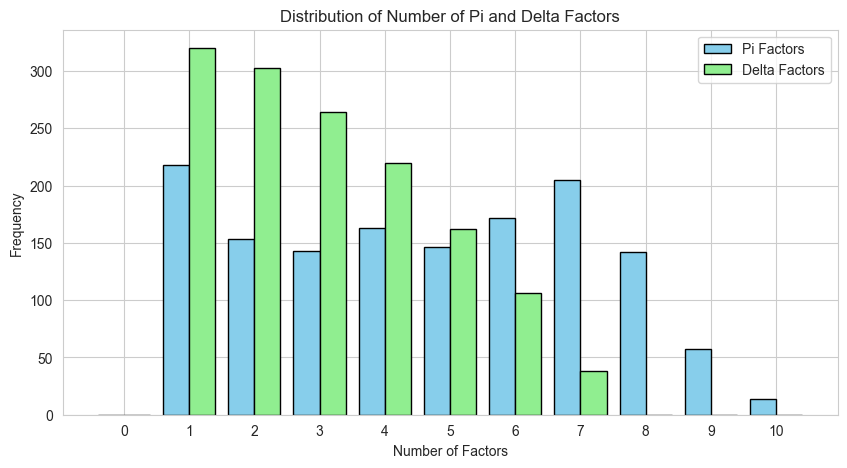

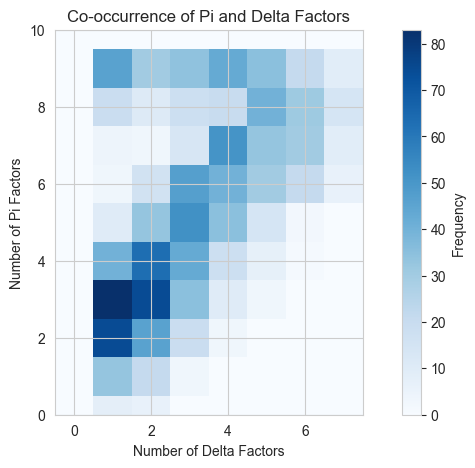

In [125]:
def factors_descriptive_stats(data):
    cases = [Case.from_dict(c) for c in data]
    cb = CaseBase(cases)
    filtered_cases = cb.cases # filtered out the empty side cases
    
    print(f"Number of cases with an empty factorset side {len(cases)-len(filtered_cases)}")
    
    pi_counts = []  # Store the number of pi factors for each case
    delta_counts = []  # Store the number of delta factors for each case
    
    
    for case in filtered_cases:
        count_pi = len(case.pi_factors)
        count_delta = len(case.delta_factors)
        pi_counts.append(count_pi)
        delta_counts.append(count_delta)
    
    # Create histograms
    plt.figure(figsize=(10, 5))
    plt.hist([pi_counts, delta_counts], bins=range(max(max(pi_counts), max(delta_counts)) + 2), color=['skyblue', 'lightgreen'], label=['Pi Factors', 'Delta Factors'], edgecolor='black', align='left')
    
    plt.xlabel('Number of Factors')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Pi and Delta Factors')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(max(max(pi_counts), max(delta_counts)) + 1))
    plt.show()
    
    # Calculate co-occurrence matrix
    cooccurrence_matrix = np.zeros((max(pi_counts) + 1, max(delta_counts) + 1))
    for pi, delta in zip(pi_counts, delta_counts):
        cooccurrence_matrix[pi, delta] += 1
    
    # Flip the co-occurrence matrix
    cooccurrence_matrix = np.flipud(cooccurrence_matrix)
    
    # Create heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(cooccurrence_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Frequency')
    plt.xlabel('Number of Delta Factors')
    plt.ylabel('Number of Pi Factors')
    plt.title('Co-occurrence of Pi and Delta Factors')
    plt.grid(True)
    
    # Set the extent of the y-axis
    plt.ylim(0, max(pi_counts))
    
    plt.show()
    
factors_descriptive_stats(data)

In [175]:
from collections import defaultdict

def test_factors_incons(data, repeats=50):
    # Set the seed for reproducibility
    random.seed(42)
    
    def add_dict(dic, factors):
        for factor in factors:
            dic[factor.name] += 1
        return dic
        
    pi_df = {}
    delta_df = {}
    
    for k in range(repeats+1):
        temp_data = data
        random.shuffle(temp_data)
        cb = CaseBase([])  
        pi_factors = defaultdict(int)
        delta_factors = defaultdict(int)
        for case in temp_data:
            new_case = Case.from_dict(case)
            polarity = new_case.decision
            if not cb.add_case(new_case, "NO"):
                if polarity == decision_enum.pi:
                    pi_factors = add_dict(pi_factors, new_case.reason)
                    delta_factors = add_dict(delta_factors, new_case.defeated())
                else:
                    pi_factors = add_dict(pi_factors, new_case.defeated())
                    delta_factors = add_dict(delta_factors, new_case.reason)
                break
                
        pi_df[k] = pi_factors
        delta_df[k] = delta_factors

    return pd.DataFrame(pi_df), pd.DataFrame(delta_df)

def incons_percentage(pi_df, delta_df):
    # Count the number of inconsistent factors for each factor name
    inconsistent_counts_pi = pi_df.transpose().apply(pd.Series.value_counts).fillna(0).astype(int).transpose()
    inconsistent_counts_delta = delta_df.transpose().apply(pd.Series.value_counts).fillna(0).astype(int).transpose()
    
    # Calculate the percentage of inconsistency for each factor
    total_cases = len(pi_df.transpose())
    inconsistent_percentage_pi = (inconsistent_counts_pi[1.0] / total_cases) * 100
    inconsistent_percentage_delta = (inconsistent_counts_delta[1.0] / total_cases) * 100
    
    return inconsistent_percentage_pi, inconsistent_percentage_delta

repeats = 1000
pi_df, delta_df = test_factors_incons(data, repeats)

In [176]:
pi_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
OnlineBackup_False,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN
Contract_Month-to-month,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
PaperlessBilling,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN
TechSupport_False,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0
PaymentMethod_Electronic check,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
DeviceProtection_False,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity_False,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
InternetService_Fiber optic,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
StreamingMovies_False,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0
StreamingTV_False,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0


In [177]:
delta_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
OnlineSecurity_True,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
InternetService_DSL,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
Partner,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
Dependents,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService_No,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
TechSupport_True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
PaymentMethod_Bank transfer (automatic),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Contract_Two year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod_Credit card (automatic),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
Contract_One year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


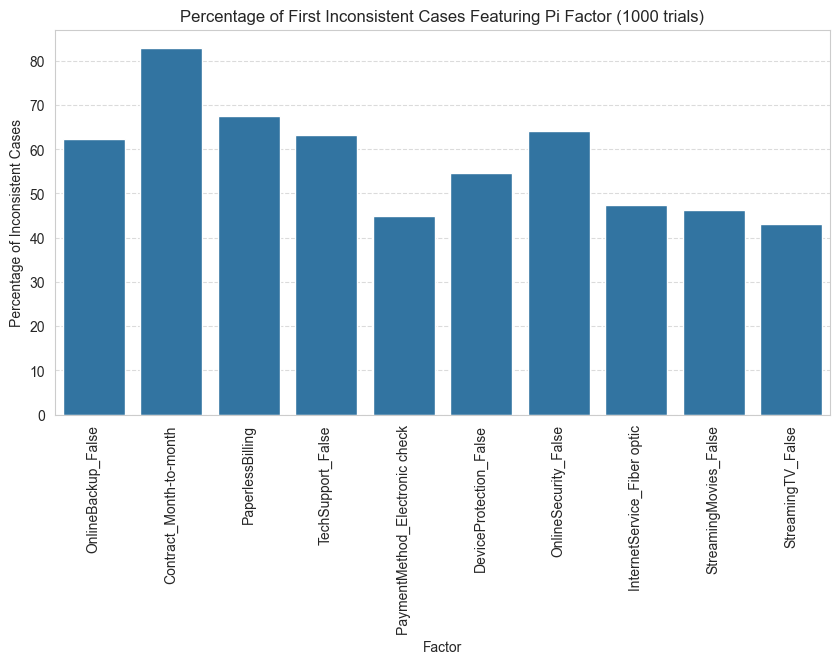

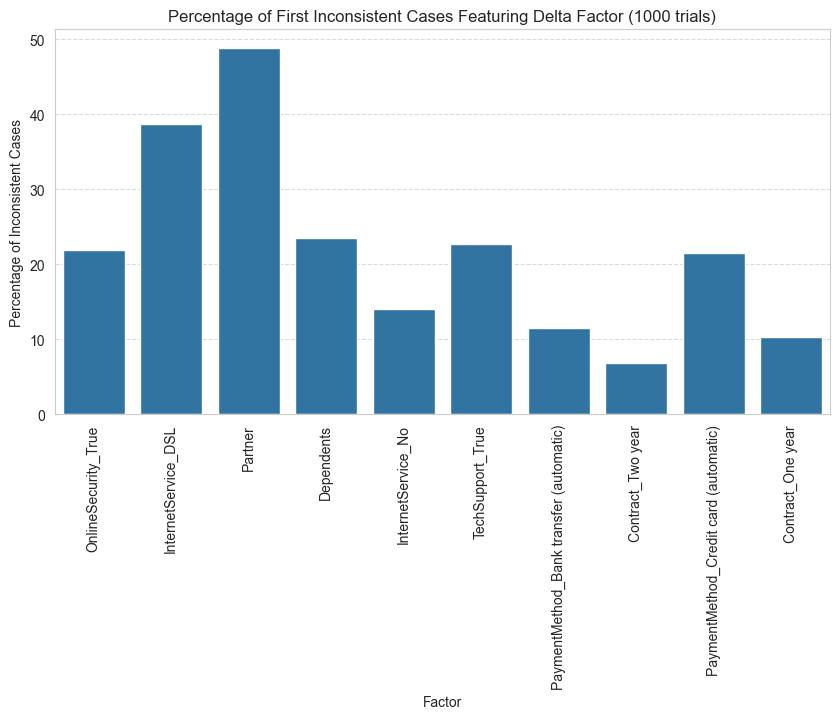

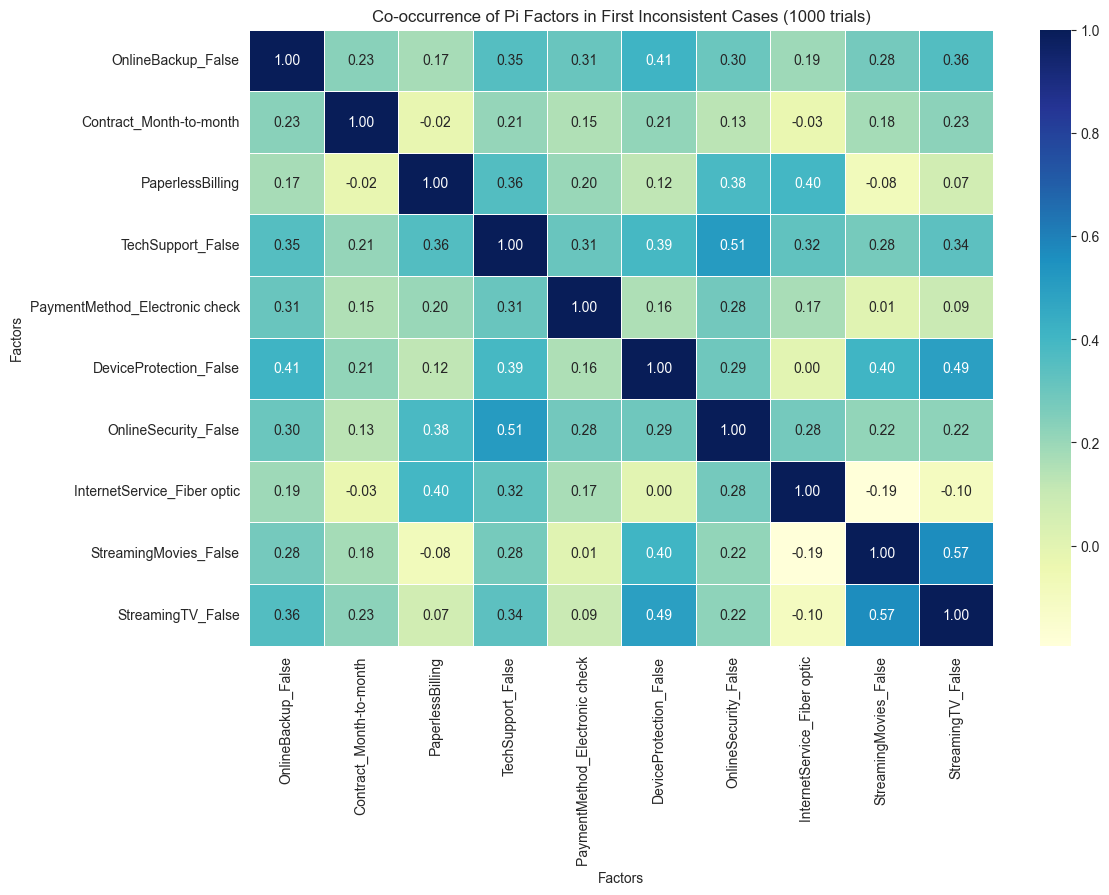

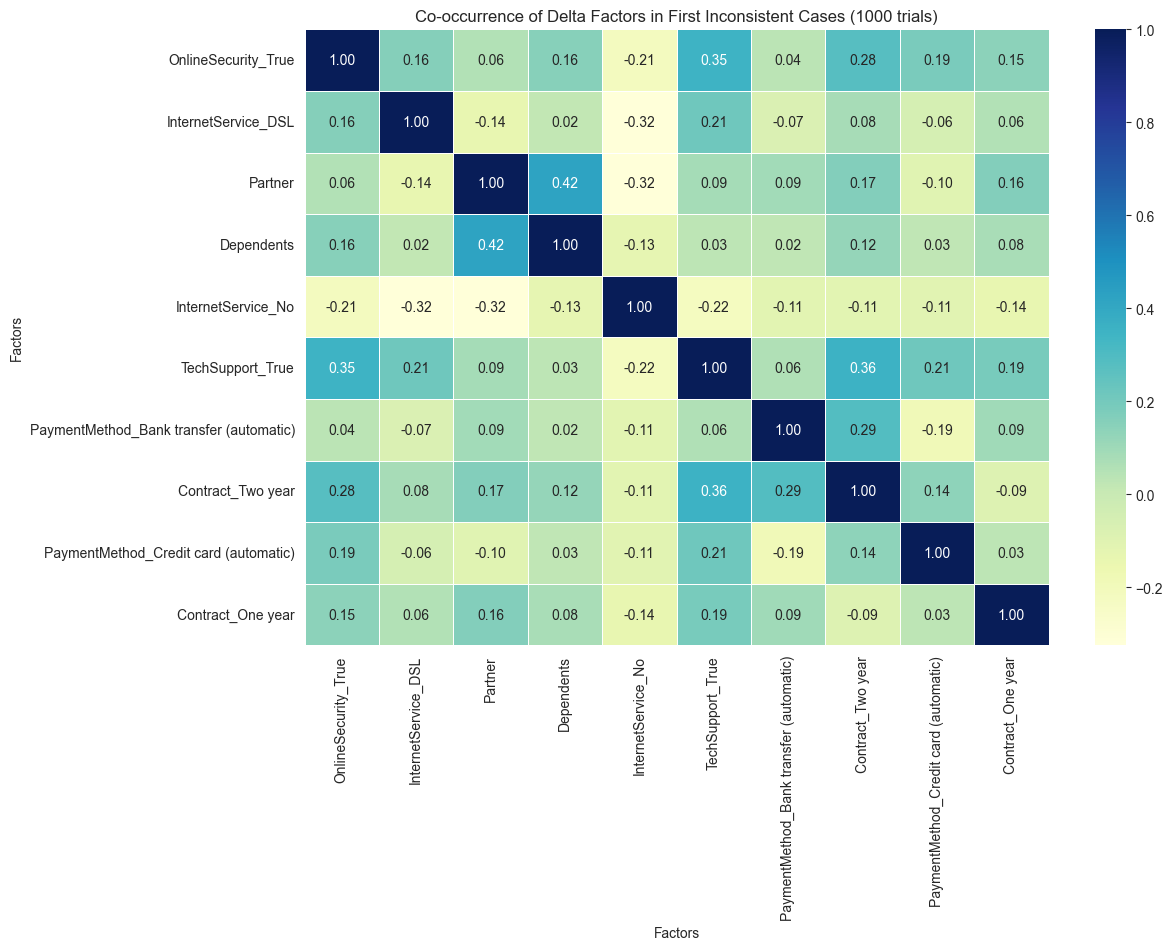

In [178]:
# 1. Factors More Likely to be Inconsistent
inconsistent_percentage_pi, inconsistent_percentage_delta = incons_percentage(pi_df, delta_df)

# Visualize the distribution of inconsistency across factors
plt.figure(figsize=(10, 5))
sns.barplot(x=inconsistent_percentage_pi.index, y=inconsistent_percentage_pi.values)
plt.title(f"Percentage of First Inconsistent Cases Featuring Pi Factor ({repeats} trials)")
plt.xlabel("Factor")
plt.ylabel("Percentage of Inconsistent Cases")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize the distribution of inconsistency across factors
plt.figure(figsize=(10, 5))
sns.barplot(x=inconsistent_percentage_delta.index, y=inconsistent_percentage_delta.values)
plt.title(f"Percentage of First Inconsistent Cases Featuring Delta Factor ({repeats} trials)")
plt.xlabel("Factor")
plt.ylabel("Percentage of Inconsistent Cases")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute the frequency of co-occurrence of inconsistencies between pairs of factors
cooccurrence_matrix_pi = pi_df.fillna(0).transpose().corr()

# Visualize the co-occurrence matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cooccurrence_matrix_pi, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title(f"Co-occurrence of Pi Factors in First Inconsistent Cases ({repeats} trials)")
plt.xlabel("Factors")
plt.ylabel("Factors")
plt.show()

# Compute the frequency of co-occurrence of inconsistencies between pairs of factors
cooccurrence_matrix_delta = delta_df.fillna(0).transpose().corr()

# Visualize the co-occurrence matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cooccurrence_matrix_delta, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title(f"Co-occurrence of Delta Factors in First Inconsistent Cases ({repeats} trials)")
plt.xlabel("Factors")
plt.ylabel("Factors")
plt.show()

## Remove factors over % inconsistency occurrence



Percentage inconsistency of factors 20
0: The number of cases we can admit before we create an inconsistency 0
1: The number of cases we can admit before we create an inconsistency 0
2: The number of cases we can admit before we create an inconsistency 0
3: The number of cases we can admit before we create an inconsistency 0
4: The number of cases we can admit before we create an inconsistency 0
5: The number of cases we can admit before we create an inconsistency 0
6: The number of cases we can admit before we create an inconsistency 0
7: The number of cases we can admit before we create an inconsistency 0
8: The number of cases we can admit before we create an inconsistency 0
9: The number of cases we can admit before we create an inconsistency 0
10: The number of cases we can admit before we create an inconsistency 0
11: The number of cases we can admit before we create an inconsistency 0
12: The number of cases we can admit before we create an inconsistency 0
13: The number of ca

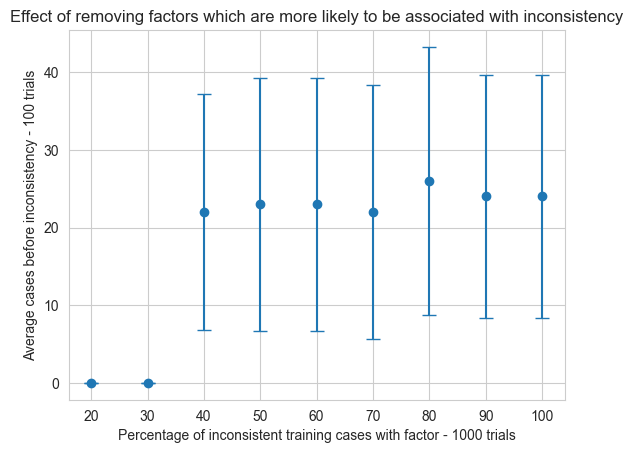

In [193]:
from sklearn.model_selection import train_test_split

def remove_factors_data(train_data, pi_factors, delta_factors):
    df = pd.DataFrame(train_data)
    # Remove factors from PI_factors column
    df['pi'] = df['pi'].apply(lambda x: [factor for factor in x if factor in pi_factors])
    # Remove factors from Delta_factors column
    df['delta'] = df['delta'].apply(lambda x: [factor for factor in x if factor in delta_factors])
    
    df['reason'] = df['reason'].apply(lambda x: [factor for factor in x if factor in delta_factors or factor in pi_factors])
    return df

def remove_factors_incons(train_data, inconsistent_percentage_pi, inconsistent_percentage_delta, perc):
    # Filter factors with inconsistency occurrence over %
    filtered_factors_pi = inconsistent_percentage_pi[inconsistent_percentage_pi <= perc]
    filtered_factors_delta = inconsistent_percentage_delta[inconsistent_percentage_delta <= perc]
    
    # Get the names of factors to keep
    factors_to_keep_pi = filtered_factors_pi.index.tolist()
    factors_to_keep_delta = filtered_factors_delta.index.tolist()
    
    # # Print the factors to keep
    # print(f"Pi Factors to keep {len(factors_to_keep_pi)}: {factors_to_keep_pi}")
    # print(f"Delta Factors to keep {len(factors_to_keep_delta)}: {factors_to_keep_delta}")
    # 
    new_data = remove_factors_data(train_data, factors_to_keep_pi, factors_to_keep_delta).to_dict(orient='records')
    return new_data
    
def remove_factors_experiment(data):
    percentages = [20, 30, 40, 50, 60, 70, 80, 90, 100]
    train_data, test_data = train_test_split(data, test_size=0.5, random_state=42)
    repeats_train = 1000
    pi_df_tr, delta_df_tr = test_factors_incons(train_data, repeats_train)
    incons_perc_pi_tr, incons_perc_delta_tr = incons_percentage(pi_df_tr, delta_df_tr)
    repeats_test = 100
    test_data_shuffles = shuffle_data(test_data, repeats_test)
    avgs = []
    stds = []
    for perc in percentages:
        print(f"\n\nPercentage inconsistency of factors {perc}")
        filtered_shuffles = []
        for shuffle in test_data_shuffles:
            filtered_shuffles.append(remove_factors_incons(shuffle, incons_perc_pi_tr, incons_perc_delta_tr, perc))
        avg, std = test_admit_bf_incons(filtered_shuffles)
        avgs.append(avg)
        stds.append(std)
        
    # Visualize the results
    plt.errorbar(percentages, avgs, yerr=stds, fmt='o', capsize=5)
    plt.xlabel(f'Percentage of inconsistent training cases with factor - {repeats_train} trials')
    plt.ylabel(f'Average cases before inconsistency - {repeats_test} trials')
    plt.title('Effect of removing factors which are more likely to be associated with inconsistency')
    plt.grid(True)
    plt.show()
        
remove_factors_experiment(data)

# Strength Experiment

In [195]:
def test_powers(data):
    cases = [Case.from_dict(c) for c in data]
    cb = CaseBase(cases)
    filtered_cases = cb.cases # filtered out the empty side cases
    powers = []
    for case in filtered_cases:
        power = cb.order.PD.case_power(case)
        powers.append(power)
        if power == 0: 
            print(case)
    
    return powers
    
powers = test_powers(data)

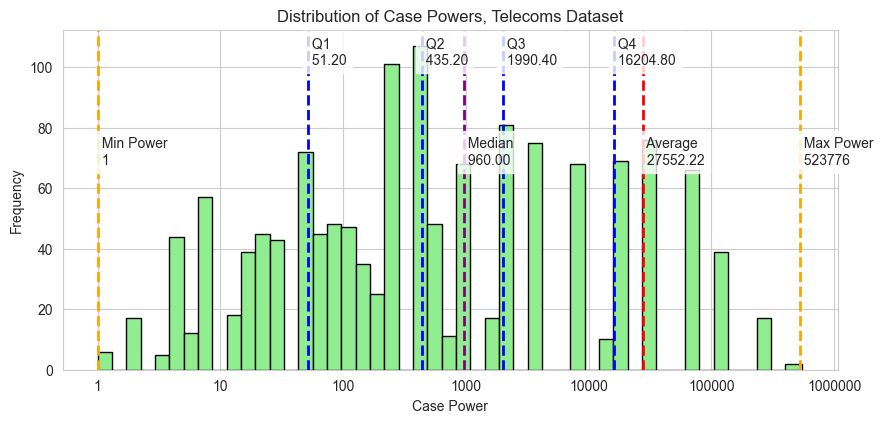

In [196]:
# Assuming 'powers' is your data
unique_powers, power_counts = np.unique(powers, return_counts=True)

# Calculate quintiles
power_quintiles = np.percentile(unique_powers, [20, 40, 60, 80])

# Calculate bin edges
bin_edges = np.logspace(np.log10(min(unique_powers)), np.log10(max(unique_powers)), 50)
bin_edges[-1] *= 1.05  # Extend the last bin to ensure it includes the maximum power value

# Plotting the histogram with a log scale on the x-axis
plt.figure(figsize=(10, 5))
plt.hist(powers, bins=bin_edges, color='lightgreen', edgecolor='black')
plt.xscale('log')
plt.title('Distribution of Case Powers, Telecoms Dataset')
plt.xlabel('Case Power')
plt.ylabel('Frequency')
plt.grid(True, axis='y')  # Grid on y-axis only for better visibility of frequencies

# Define tick positions for the x-axis
tick_positions = [1, 10, 100, 1000, 10000, 100000, 1000000]

# Set custom ticks and labels for the x-axis
plt.xticks(tick_positions, [str(int(tick)) for tick in tick_positions])

# Mark quintiles and their original power numbers
for quintile in power_quintiles:
    plt.axvline(quintile, color='blue', linestyle='dashed', linewidth=2)
    plt.text(quintile, 100, f' Q{np.where(power_quintiles == quintile)[0][0] + 1} \n {quintile:.2f}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin

# Mark the average
power_average = np.mean(unique_powers)
plt.axvline(power_average, color='red', linestyle='dashed', linewidth=2)
plt.text(power_average, max(power_counts)+10, f' Average \n {power_average:.2f}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

# Calculate median
power_median = np.median(unique_powers)
plt.axvline(power_median, color='purple', linestyle='dashed', linewidth=2)
plt.text(power_median, max(power_counts)+10, f' Median \n {power_median:.2f}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

# Mark the maximum power possible
max_power = max(unique_powers)
plt.axvline(max_power, color='orange', linestyle='dashed', linewidth=2)
plt.text(max_power, max(power_counts)+10, f' Max Power \n {max_power}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

# Mark the minimum power possible
min_power = min(unique_powers)
plt.axvline(min_power, color='orange', linestyle='dashed', linewidth=2)
plt.text(min_power, max(power_counts)+10, f' Min Power \n {min_power}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

In [199]:
def test_admit_bf_incons(data, repeats=50):
    # Set the seed for reproducibility
    random.seed(42)
    scores = []
    powers = []
    for k in range(repeats+1):
        temp_data = data
        random.shuffle(temp_data)
        cb = CaseBase([])  
        score = 0
        for i in range(len(temp_data)):
            new_case = Case.from_dict(temp_data[i])
            if not cb.add_case(new_case, "NO"):
                score = i
                cb_power = cb.order.PD.cb_power()
                break
        powers.append(cb_power)
        scores.append(score)
        print(f"{k}: The number of cases we can admit before we create an inconsistency {score}")
        print(f"{k}: The power of case base before we create an inconsistency {cb_power}")
        print()
    
    return scores, powers
repeats = 1000
scores, powers = test_admit_bf_incons(TC.get_existing_test_data(), repeats)


Loaded data successfully from 'data/telco-corr-test-0.25.yaml'
0: The number of cases we can admit before we create an inconsistency 56
0: The power of case base before we create an inconsistency 50931

1: The number of cases we can admit before we create an inconsistency 28
1: The power of case base before we create an inconsistency 304338
2: The number of cases we can admit before we create an inconsistency 70
2: The power of case base before we create an inconsistency 283563

3: The number of cases we can admit before we create an inconsistency 17
3: The power of case base before we create an inconsistency 54208

4: The number of cases we can admit before we create an inconsistency 35
4: The power of case base before we create an inconsistency 161086

5: The number of cases we can admit before we create an inconsistency 15
5: The power of case base before we create an inconsistency 67819
6: The number of cases we can admit before we create an inconsistency 39
6: The power of case ba

In [200]:
import statistics

avg = round(sum(scores) / repeats)
std_dev = round(statistics.stdev(scores), 2)
print(f"Average cases before inconsistency ({repeats} trials): {avg}")
print(f"Standard deviation: {std_dev}")


avg = round(sum(powers) / repeats)
std_dev = round(statistics.stdev(powers), 2)
print(f"Average power score ({repeats} trials): {avg}")
print(f"Standard deviation: {std_dev}")

Average cases before inconsistency (1000 trials): 25
Standard deviation: 15.13
Average power score (1000 trials): 155127
Standard deviation: 121549.05


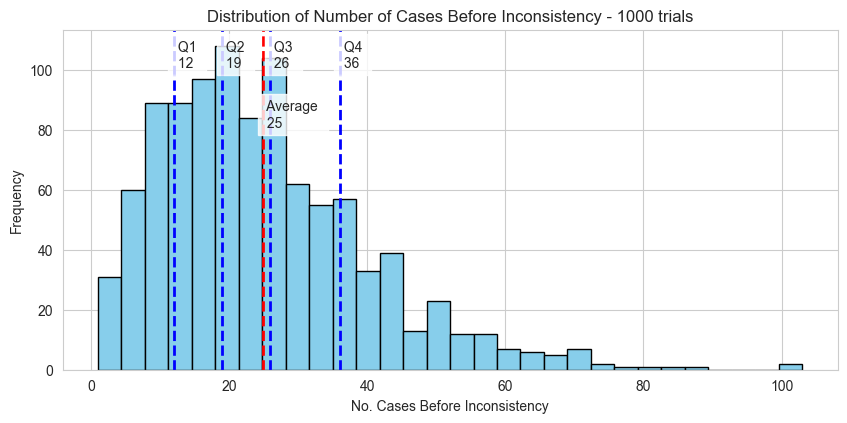

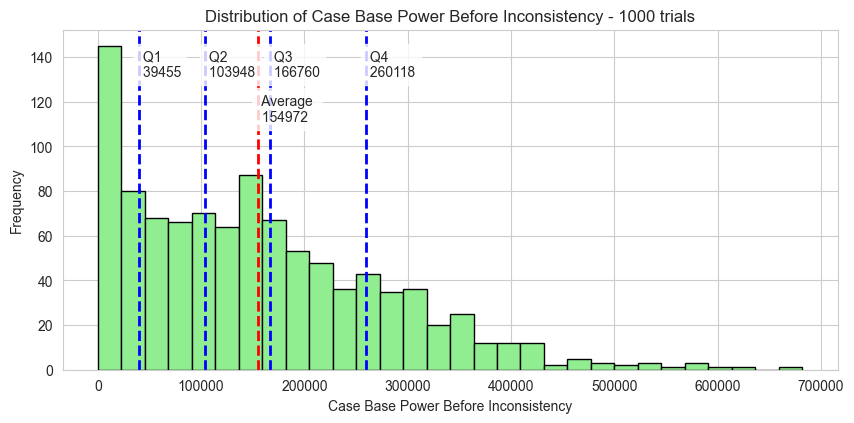

In [201]:
# Calculating quintiles
score_quintiles = np.percentile(scores, [20, 40, 60, 80])
power_quintiles = np.percentile(powers, [20, 40, 60, 80])

# Calculate averages
score_average = np.mean(scores)
power_average = np.mean(powers)

# Plotting inconsistency scores with quintiles
plt.figure(figsize=(10, 5))
plt.hist(scores, bins=30, color='skyblue', edgecolor='black')

# Mark quintiles and their original power numbers
for quintile in score_quintiles:
    plt.axvline(quintile, color='blue', linestyle='dashed', linewidth=2)
    plt.text(quintile, 100, f' Q{np.where(score_quintiles == quintile)[0][0] + 1} \n {quintile:.0f}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))
plt.axvline(score_average, color='red', linestyle='dashed', linewidth=2)
plt.text(score_average, 80, f' Average \n {score_average:.0f}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin

plt.title(f'Distribution of Number of Cases Before Inconsistency - {repeats} trials')
plt.xlabel('No. Cases Before Inconsistency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting power scores with quintiles
plt.figure(figsize=(10, 5))
plt.hist(powers, bins=30, color='lightgreen', edgecolor='black')

# Mark quintiles and their original power numbers
for quintile in power_quintiles:
    plt.axvline(quintile, color='blue', linestyle='dashed', linewidth=2)
    plt.text(quintile, 130, f' Q{np.where(power_quintiles == quintile)[0][0] + 1} \n {quintile:.0f}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))
plt.axvline(power_average, color='red', linestyle='dashed', linewidth=2)
plt.text(power_average, 110, f' Average \n {power_average:.0f}', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin

plt.title(f'Distribution of Case Base Power Before Inconsistency - {repeats} trials')
plt.xlabel('Case Base Power Before Inconsistency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()